In [264]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
import matplotlib.pyplot as plt
import shap
shap.initjs()
from models import mape as calc_mape

In [265]:
stations = pd.read_csv('data\clean\hourly_uniformly_azk.csv')
stations.head()

,time,kWh,Latitude,Longitude,InternalNum
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100


In [266]:
locations = pd.read_csv('data\locations.csv')
locations.head()

,Unnamed: 0,Унікод АЗС,Address,Number,Region,Latitude,Longitude
0,0,28410100.0,"м. Київ, просп. Леся Курбаса, 2 Ж",АЗС-47,м. Київ,50.43104,30.39037
1,1,25840200.0,"м. Київ, вул. Новокостянтинівська, 4 Ж",АЗС-62,м. Київ,50.48207,30.48725
2,2,40112300.0,"м. Стрий, вул. Болехівська, 49",АЗС-23,Львів,49.24778,23.85610
3,3,40512100.0,"Надвірнянський р-н, м. Надвірна, вул. Вокзальн...",АЗС-21,Івано-Франківськ,48.62307,24.58351
4,4,60961300.0,"м. Київ, просп. Академіка Палладіна, 33",АЗС-63,м. Київ,50.46754,30.35680


In [267]:
distinct_values = locations['Region'].unique()
print("Distinct values:", distinct_values)

Distinct values: ['м. Київ' 'Львів' 'Івано-Франківськ' 'Дніпропетровськ' 'Київ' 'Харків'
 'Чернівецька' 'Одеса' 'Черкаси' 'Закарпаття' 'Рівне' 'Кіровоград'
 'Полтава' 'Житомир' 'Волинь']


In [268]:
joined = pd.merge(stations, locations, left_on='InternalNum', right_on='Унікод АЗС', how='inner')
columns_to_select = ['time', 'kWh', 'Latitude_x', 'Longitude_x', 'InternalNum', 'Region']
final_df = joined[columns_to_select]
final_df.head()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100,м. Київ
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100,м. Київ
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100,м. Київ


<font>
<font size = '10'>
<center><b>Київ</b></center></font>

In [269]:
kyiv_stations = final_df[(final_df['Region'] == 'м. Київ') | (final_df['Region'] == 'Київ')]
lviv_stations = final_df[final_df['Region'] == 'Львів']
ivano_frankivsk_stations = final_df[final_df['Region'] == 'Івано-Франківськ']
dnipro_stations = final_df[final_df['Region'] == 'Дніпропетровськ']
kharkiv_stations = final_df[final_df['Region'] == 'Харків']
chernivtsi_stations = final_df[final_df['Region'] == 'Чернівецька']
odesa_stations = final_df[final_df['Region'] == 'Одеса']
cherkasy_stations = final_df[final_df['Region'] == 'Черкаси']
zakarpatya_stations = final_df[final_df['Region'] == 'Закарпаття']
rivne_stations = final_df[final_df['Region'] == 'Рівне']
kropyvnytskyi_stations = final_df[final_df['Region'] == 'Кіровоград']
poltava_stations = final_df[final_df['Region'] == 'Полтава']
zhytomyr_stations = final_df[final_df['Region'] == 'Житомир']
volyn_stations = final_df[final_df['Region'] == 'Волинь']

In [270]:
kyiv_stations.head()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100,м. Київ
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100,м. Київ
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100,м. Київ


In [272]:
kyiv_stations['time'] = pd.to_datetime(kyiv_stations['time'])

kyiv_stations['year'] = kyiv_stations['time'].dt.year
kyiv_stations['month'] = kyiv_stations['time'].dt.month
kyiv_stations['day'] = kyiv_stations['time'].dt.day
kyiv_stations['day_of_week'] = kyiv_stations['time'].dt.weekday
kyiv_stations['hour'] = kyiv_stations['time'].dt.hour

kyiv_stations.tail()

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_stations['time'] = pd.to_datetime(kyiv_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_stations['year'] = kyiv_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region,year,month,day,day_of_week,hour
1535291,2024-10-31 03:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,3
1535292,2024-10-31 04:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,4
1535293,2024-10-31 05:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,5
1535294,2024-10-31 06:00:00,32.52,50.34903,30.95535,40861000,Київ,2024,10,31,3,6
1535295,2024-10-31 07:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,7


In [273]:
# Filter for test (October 2024)
test_kyiv = kyiv_stations[(kyiv_stations['time'].dt.year == 2024) & (kyiv_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_kyiv = kyiv_stations[(kyiv_stations['time'].dt.year == 2024) & (kyiv_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_kyiv = kyiv_stations[kyiv_stations['time'] < '2024-09-01']

In [274]:
features = ['Latitude_x', 'Longitude_x', 'year', 'month', 'day', 'day_of_week', 'hour']
target = 'kWh'

In [275]:
X_train = train_kyiv[features]
y_train = train_kyiv[target]

X_valid = validation_kyiv[features]
y_valid = validation_kyiv[target]

In [276]:
train_kyiv = kyiv_stations[(kyiv_stations['time'] > '2023-01-01') & (kyiv_stations['time'] < '2024-09-01')]
X_train = train_kyiv[features]
y_train = train_kyiv[target]

In [277]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "tree_method": "auto",
        "n_jobs": 4,
    }

    # Train the XGBoost model
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train, verbose=0)

    # Predict and calculate RMSE
    valid_preds = xgb_model.predict(X_valid)
    valid_preds = np.clip(valid_preds, 0, None)
    mape = calc_mape(y_valid, valid_preds)
    return mape

# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_mape = calc_mape(y_valid, final_preds)
print(f"Optimized XGB MAPE: {final_mape}")

[I 2024-12-18 23:22:51,858] A new study created in memory with name: no-name-354ef927-dda4-4d8b-bde5-6530d6fa2786
[I 2024-12-18 23:23:03,043] Trial 0 finished with value: 2.751302177573927 and parameters: {'n_estimators': 600, 'max_depth': 11, 'learning_rate': 0.08046697310618889, 'subsample': 0.5829202729742198, 'colsample_bytree': 0.8432118211273019, 'gamma': 4.060026272273537, 'lambda': 1.2918403701847536, 'alpha': 0.017932590609611887}. Best is trial 0 with value: 2.751302177573927.
[I 2024-12-18 23:23:12,679] Trial 1 finished with value: 3.019806546918738 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1084683690436181, 'subsample': 0.6166971226903266, 'colsample_bytree': 0.9891950318008297, 'gamma': 8.254842754823034, 'lambda': 0.39069603610604037, 'alpha': 0.001953239423667127}. Best is trial 0 with value: 2.751302177573927.
[I 2024-12-18 23:23:18,724] Trial 2 finished with value: 2.774438031425511 and parameters: {'n_estimators': 150, 'max_depth': 15, 

Best Parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.03130617978726634, 'subsample': 0.9474235577636901, 'colsample_bytree': 0.6491706384028132, 'gamma': 4.149903487589694, 'lambda': 0.0017446916963708052, 'alpha': 0.0024362189098713623}
Optimized XGB MAPE: 2.287427691127885


In [278]:
X_test = test_kyiv[features]
y_test = test_kyiv[target]

In [279]:
def xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test):
    xgb_model = xgb.XGBRegressor(**study.best_params)
    xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]), verbose=0)

    test_preds = xgb_model.predict(X_test)
    test_preds = np.clip(test_preds, 0, None)
    mape = calc_mape(y_test, test_preds)
    print(f'Test MAPE: {mape}')
    return test_preds

kyiv_preds = xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test MAPE: 2.531414561040107


In [280]:
test_kyiv = test_kyiv.reset_index()

In [281]:
kyiv_preds_df = pd.DataFrame(kyiv_preds, columns=['preds'])
kyiv_preds_df['unicode'] = test_kyiv['InternalNum']
kyiv_preds_df['time'] = test_kyiv['time']
kyiv_preds_df.head()

,preds,unicode,time
0,0.290285,28410100,2024-10-01 00:00:00
1,0.000000,28410100,2024-10-01 01:00:00
2,0.000000,28410100,2024-10-01 02:00:00
3,0.000000,28410100,2024-10-01 03:00:00
4,0.032098,28410100,2024-10-01 04:00:00


In [282]:
distinct_kyiv = test_kyiv['InternalNum'].unique()

In [283]:
kyiv_station_rmse = {}

for station in distinct_kyiv:
    cut_preds = kyiv_preds_df[kyiv_preds_df['unicode'] == station]
    cut_test = test_kyiv[test_kyiv['InternalNum'] == station]
    mape = calc_mape(cut_preds['preds'], cut_test['kWh'])
    kyiv_station_rmse[station] = mape

# Sort stations by RMSE
sorted_stations = sorted(kyiv_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

Best RMSE: 0.1866 (Station: 40814300)
Median RMSE: 0.8696 (Station: 60960400)
Worst RMSE: 1.9888 (Station: 40861500)


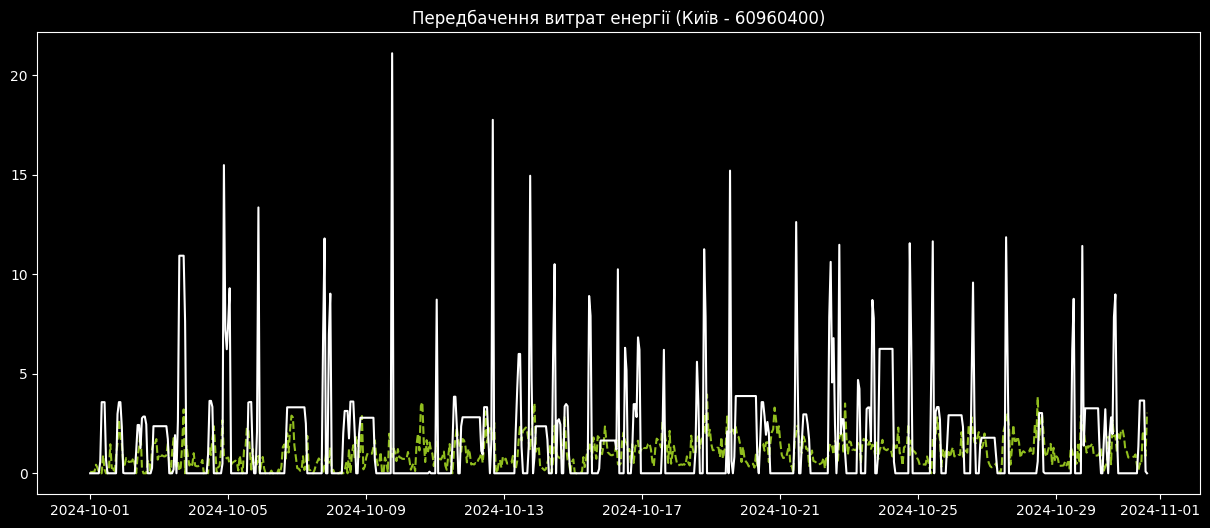

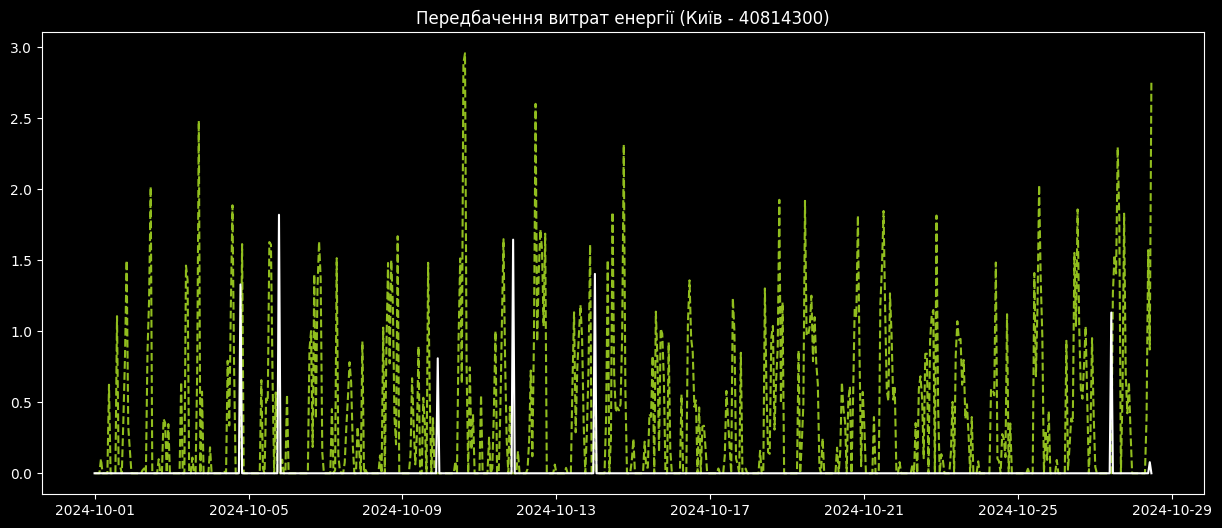

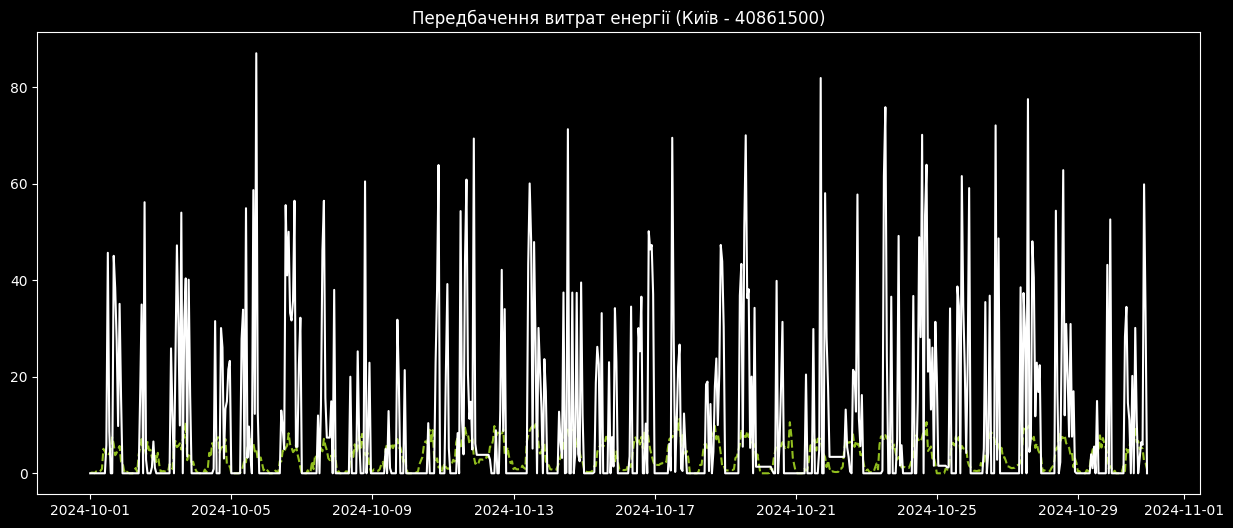

In [284]:
cut_preds_median = kyiv_preds_df[kyiv_preds_df['unicode'] == median_station]
cut_test_median = test_kyiv[test_kyiv['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Київ - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = kyiv_preds_df[kyiv_preds_df['unicode'] == best_station]
cut_test_median = test_kyiv[test_kyiv['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Київ - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = kyiv_preds_df[kyiv_preds_df['unicode'] == worst_station]
cut_test_median = test_kyiv[test_kyiv['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Київ - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')

<font>
<font size = '10'>
<center><b>Львів</b></center></font>

In [285]:
lviv_stations['time'] = pd.to_datetime(lviv_stations['time'])

lviv_stations['year'] = lviv_stations['time'].dt.year
lviv_stations['month'] = lviv_stations['time'].dt.month
lviv_stations['day'] = lviv_stations['time'].dt.day
lviv_stations['day_of_week'] = lviv_stations['time'].dt.weekday
lviv_stations['hour'] = lviv_stations['time'].dt.hour

lviv_stations.tail()

# Filter for test (October 2024)
test_lviv = lviv_stations[(lviv_stations['time'].dt.year == 2024) & (lviv_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_lviv = lviv_stations[(lviv_stations['time'].dt.year == 2024) & (lviv_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_lviv = lviv_stations[(lviv_stations['time'] > '2023-01-01') & (lviv_stations['time'] < '2024-09-01')]

X_train = train_lviv[features]
y_train = train_lviv[target]

X_valid = validation_lviv[features]
y_valid = validation_lviv[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\4123132933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lviv_stations['time'] = pd.to_datetime(lviv_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\4123132933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lviv_stations['year'] = lviv_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\4123132933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [286]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_mape = calc_mape(y_valid, final_preds)
print(f"Optimized XGB RMSE: {final_mape}")

[I 2024-12-18 23:29:02,223] A new study created in memory with name: no-name-0e628879-d582-4e04-8690-c3f6f034bdb0
[I 2024-12-18 23:29:19,200] Trial 0 finished with value: 4.206102203607161 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.18025440435720363, 'subsample': 0.507474137468231, 'colsample_bytree': 0.7028178678380457, 'gamma': 7.198473446754003, 'lambda': 0.0031376322224953125, 'alpha': 0.0030196605106837015}. Best is trial 0 with value: 4.206102203607161.
[I 2024-12-18 23:29:20,301] Trial 1 finished with value: 3.508282653947948 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.026930597125906293, 'subsample': 0.8803536475068063, 'colsample_bytree': 0.6845784633183151, 'gamma': 9.731877536743196, 'lambda': 1.0038106166160965, 'alpha': 0.015038427609081355}. Best is trial 1 with value: 3.508282653947948.
[I 2024-12-18 23:29:34,783] Trial 2 finished with value: 3.967329416631353 and parameters: {'n_estimators': 900, 'max_depth': 

Best Parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.026569780536986956, 'subsample': 0.6909312986166939, 'colsample_bytree': 0.6902994816946236, 'gamma': 0.5633697149347108, 'lambda': 0.0177010506488824, 'alpha': 2.006736760644839}
Optimized XGB RMSE: 3.129330710672657


In [287]:
def xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test):
    xgb_model = xgb.XGBRegressor(**study.best_params)
    xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]), verbose=0)

    test_preds = xgb_model.predict(X_test)
    test_preds = np.clip(test_preds, 0, None)
    mape = calc_mape(y_test, test_preds)
    print(f'Test RMSE: {mape}')
    return test_preds

In [288]:
X_test = test_lviv[features]
y_test = test_lviv[target]

lviv_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 3.055489070366036


Best RMSE: 0.1909 (Station: 40111700)
Median RMSE: 1.3209 (Station: 40113200)
Worst RMSE: 1.5833 (Station: 40114900)


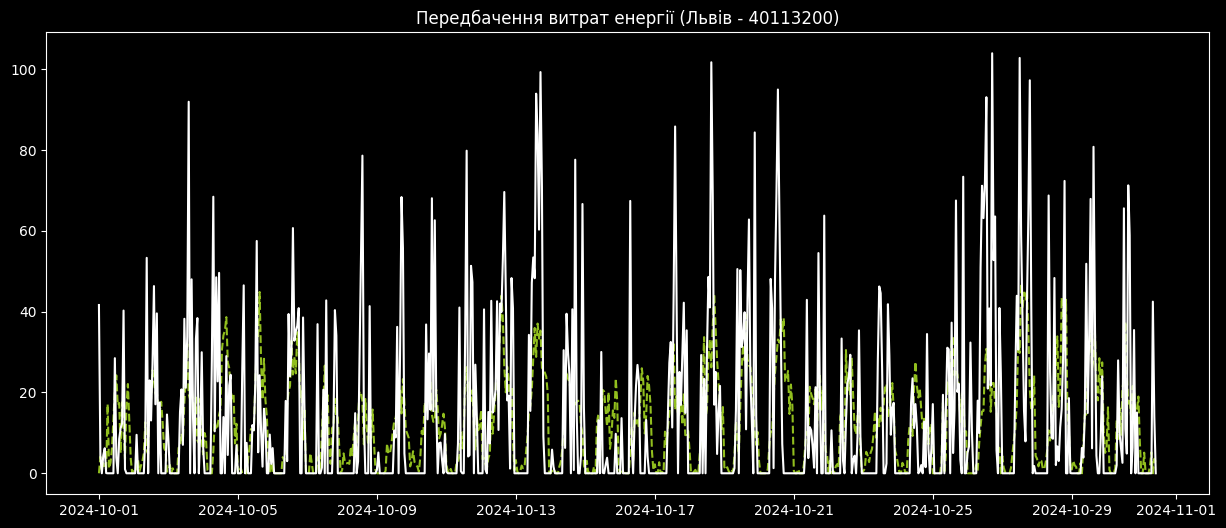

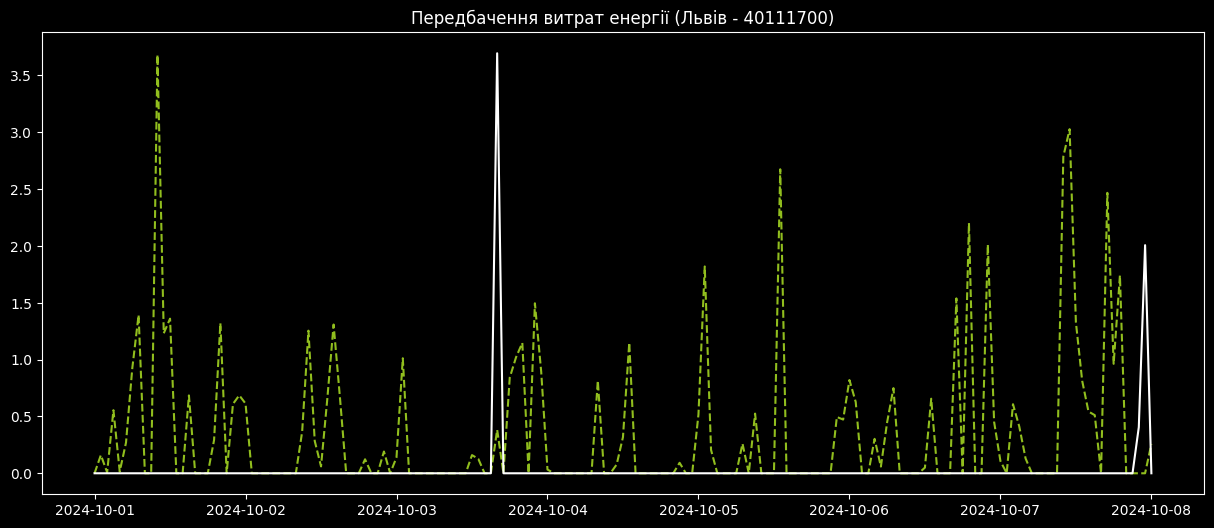

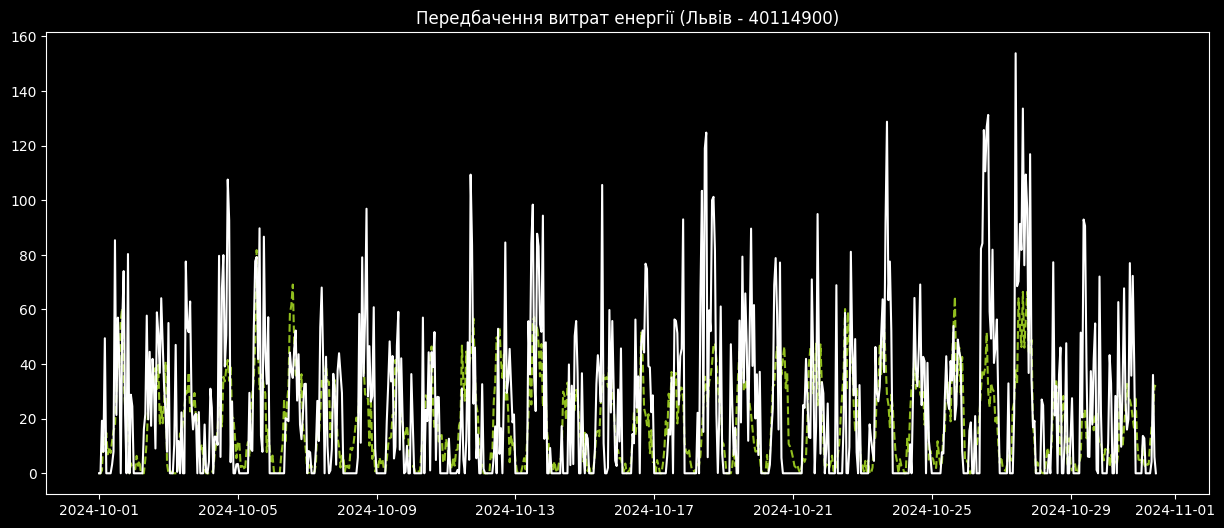

In [289]:
test_lviv = test_lviv.reset_index()
lviv_preds_df = pd.DataFrame(lviv_preds, columns=['preds'])
lviv_preds_df['unicode'] = test_lviv['InternalNum']
lviv_preds_df['time'] = test_lviv['time']
distinct_lviv = test_lviv['InternalNum'].unique()

lviv_station_rmse = {}

for station in distinct_lviv:
    cut_preds = lviv_preds_df[lviv_preds_df['unicode'] == station]
    cut_test = test_lviv[test_lviv['InternalNum'] == station]
    mape = calc_mape(cut_preds['preds'], cut_test['kWh'])
    lviv_station_rmse[station] = mape

# Sort stations by RMSE
sorted_stations = sorted(lviv_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = lviv_preds_df[lviv_preds_df['unicode'] == median_station]
cut_test_median = test_lviv[test_lviv['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Львів - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = lviv_preds_df[lviv_preds_df['unicode'] == best_station]
cut_test_median = test_lviv[test_lviv['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Львів - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = lviv_preds_df[lviv_preds_df['unicode'] == worst_station]
cut_test_median = test_lviv[test_lviv['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Львів - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')


<font>
<font size = '10'>
<center><b>Дніпро</b></center></font>

In [290]:
dnipro_stations['time'] = pd.to_datetime(dnipro_stations['time'])

dnipro_stations['year'] = dnipro_stations['time'].dt.year
dnipro_stations['month'] = dnipro_stations['time'].dt.month
dnipro_stations['day'] = dnipro_stations['time'].dt.day
dnipro_stations['day_of_week'] = dnipro_stations['time'].dt.weekday
dnipro_stations['hour'] = dnipro_stations['time'].dt.hour

dnipro_stations.tail()

# Filter for test (October 2024)
test_dnipro = dnipro_stations[(dnipro_stations['time'].dt.year == 2024) & (dnipro_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_dnipro = dnipro_stations[(dnipro_stations['time'].dt.year == 2024) & (dnipro_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_dnipro = dnipro_stations[(dnipro_stations['time'] > '2023-01-01') & (dnipro_stations['time'] < '2024-09-01')]

X_train = train_dnipro[features]
y_train = train_dnipro[target]

X_valid = validation_dnipro[features]
y_valid = validation_dnipro[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\2100384852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dnipro_stations['time'] = pd.to_datetime(dnipro_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\2100384852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dnipro_stations['year'] = dnipro_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\2100384852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [291]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_mape = calc_mape(y_valid, final_preds)
print(f"Optimized XGB RMSE: {final_mape}")

[I 2024-12-18 23:35:54,523] A new study created in memory with name: no-name-f9eeb627-9975-41a0-a9be-f7091f15e752


[I 2024-12-18 23:35:56,309] Trial 0 finished with value: 0.2512020015773247 and parameters: {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.23047797401880712, 'subsample': 0.7250620087759077, 'colsample_bytree': 0.923600002967609, 'gamma': 3.3096463744562845, 'lambda': 0.15583315591471336, 'alpha': 0.6006966672193137}. Best is trial 0 with value: 0.2512020015773247.
[I 2024-12-18 23:35:57,721] Trial 1 finished with value: 0.24632110926738082 and parameters: {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.1705606213899305, 'subsample': 0.622350848567008, 'colsample_bytree': 0.6946811638207853, 'gamma': 2.7725286164393603, 'lambda': 3.4886139541684242, 'alpha': 0.3836344238583577}. Best is trial 1 with value: 0.24632110926738082.
[I 2024-12-18 23:35:59,816] Trial 2 finished with value: 0.231420573437951 and parameters: {'n_estimators': 700, 'max_depth': 13, 'learning_rate': 0.19457950919895903, 'subsample': 0.6822003755307948, 'colsample_bytree': 0.8997889699467343, 'g

Best Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.22645241969799648, 'subsample': 0.9966938683390435, 'colsample_bytree': 0.8364663376462438, 'gamma': 7.351684069057272, 'lambda': 0.6120048182234082, 'alpha': 0.04017568366981793}
Optimized XGB RMSE: 0.15662440485158544


In [292]:
X_test = test_dnipro[features]
y_test = test_dnipro[target]

dnipro_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 0.21007074847858268


Best RMSE: 0.0982 (Station: 23460100)
Median RMSE: 0.4084 (Station: 41264000)
Worst RMSE: 0.4084 (Station: 41264000)


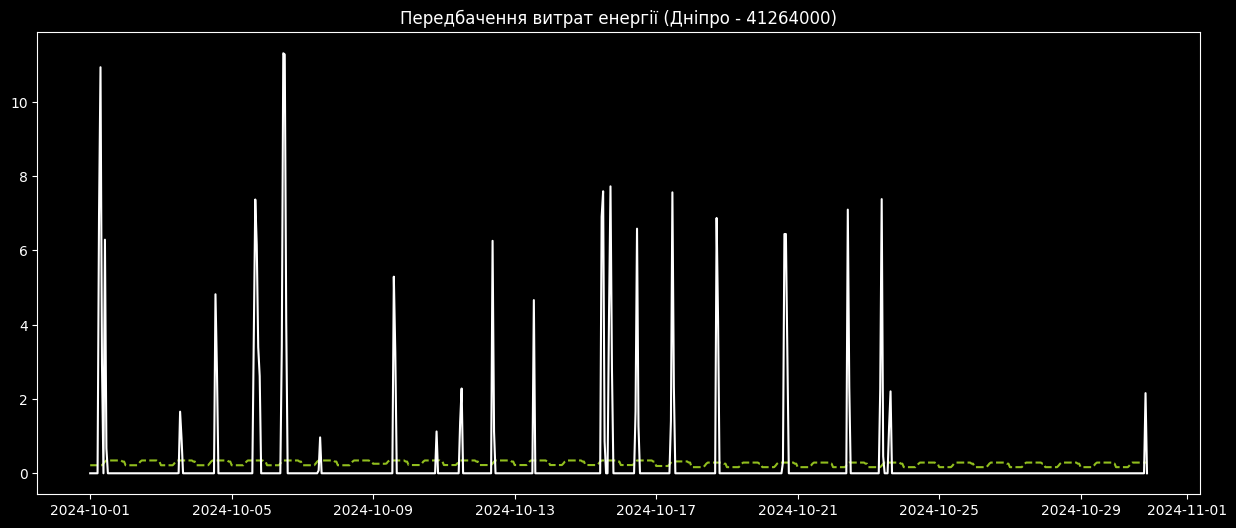

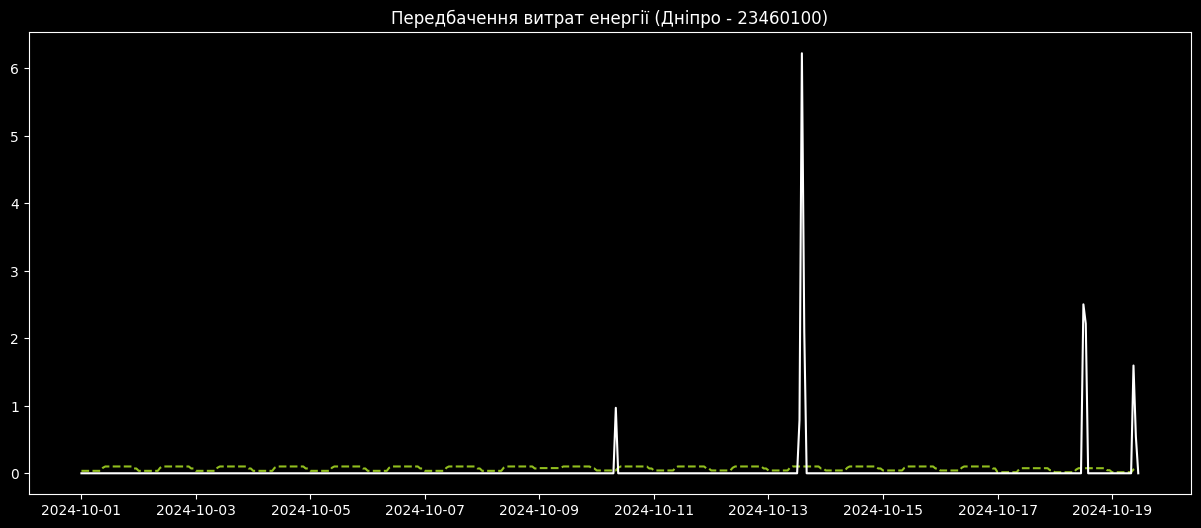

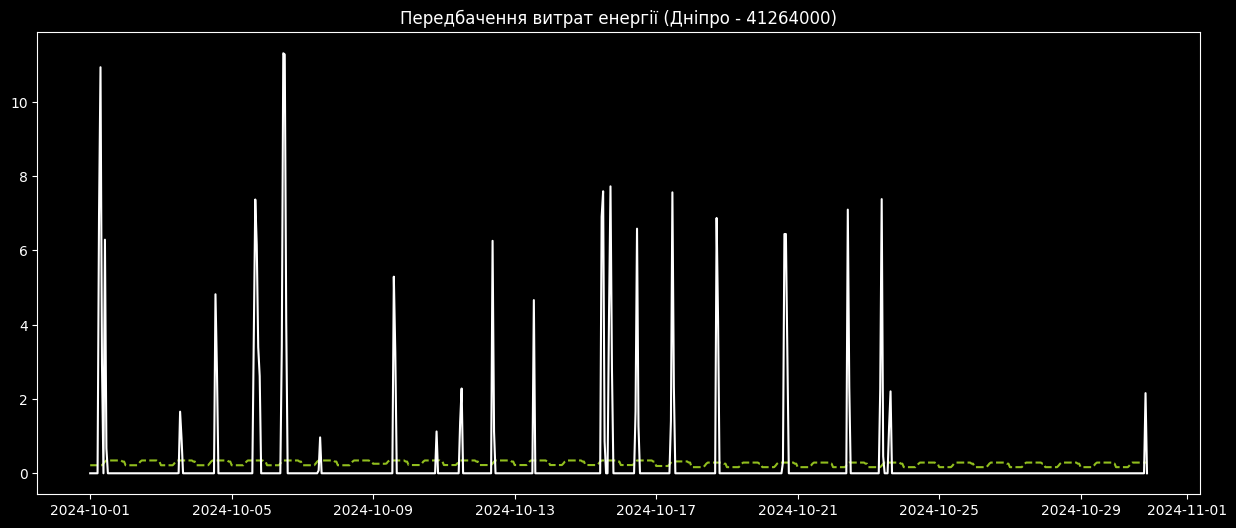

In [293]:
test_dnipro = test_dnipro.reset_index()
dnipro_preds_df = pd.DataFrame(dnipro_preds, columns=['preds'])
dnipro_preds_df['unicode'] = test_dnipro['InternalNum']
dnipro_preds_df['time'] = test_dnipro['time']
distinct_dnipro = test_dnipro['InternalNum'].unique()

dnipro_station_rmse = {}

for station in distinct_dnipro:
    cut_preds = dnipro_preds_df[dnipro_preds_df['unicode'] == station]
    cut_test = test_dnipro[test_dnipro['InternalNum'] == station]
    mape = calc_mape(cut_preds['preds'], cut_test['kWh'])
    dnipro_station_rmse[station] = mape

# Sort stations by RMSE
sorted_stations = sorted(dnipro_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = dnipro_preds_df[dnipro_preds_df['unicode'] == median_station]
cut_test_median = test_dnipro[test_dnipro['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Дніпро - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = dnipro_preds_df[dnipro_preds_df['unicode'] == best_station]
cut_test_median = test_dnipro[test_dnipro['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Дніпро - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = dnipro_preds_df[dnipro_preds_df['unicode'] == worst_station]
cut_test_median = test_dnipro[test_dnipro['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Дніпро - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')


<font>
<font size = '10'>
<center><b>Одеса</b></center></font>

In [294]:
odesa_stations['time'] = pd.to_datetime(odesa_stations['time'])

odesa_stations['year'] = odesa_stations['time'].dt.year
odesa_stations['month'] = odesa_stations['time'].dt.month
odesa_stations['day'] = odesa_stations['time'].dt.day
odesa_stations['day_of_week'] = odesa_stations['time'].dt.weekday
odesa_stations['hour'] = odesa_stations['time'].dt.hour

odesa_stations.tail()

# Filter for test (October 2024)
test_odesa = odesa_stations[(odesa_stations['time'].dt.year == 2024) & (odesa_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_odesa = odesa_stations[(odesa_stations['time'].dt.year == 2024) & (odesa_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_odesa = odesa_stations[(odesa_stations['time'] > '2023-01-01') & (odesa_stations['time'] < '2024-09-01')]

X_train = train_odesa[features]
y_train = train_odesa[target]

X_valid = validation_odesa[features]
y_valid = validation_odesa[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\280656554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odesa_stations['time'] = pd.to_datetime(odesa_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\280656554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odesa_stations['year'] = odesa_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\280656554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [295]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_mape = calc_mape(y_valid, final_preds)
print(f"Optimized XGB RMSE: {final_mape}")

[I 2024-12-18 23:37:01,747] A new study created in memory with name: no-name-d82b2df1-9bb4-428a-8c91-7bdc1e9f84fd
[I 2024-12-18 23:37:04,184] Trial 0 finished with value: 4.716358463494168 and parameters: {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 0.2928455891324369, 'subsample': 0.705686110622407, 'colsample_bytree': 0.7645936899189509, 'gamma': 8.339358596530534, 'lambda': 0.29934631054349703, 'alpha': 3.5888590238438316}. Best is trial 0 with value: 4.716358463494168.
[I 2024-12-18 23:37:06,136] Trial 1 finished with value: 4.356950283634234 and parameters: {'n_estimators': 750, 'max_depth': 12, 'learning_rate': 0.17463086895078353, 'subsample': 0.9634394276454719, 'colsample_bytree': 0.7198818326223566, 'gamma': 9.210245845294873, 'lambda': 0.015988887671153588, 'alpha': 0.0028764679072461174}. Best is trial 1 with value: 4.356950283634234.
[I 2024-12-18 23:37:12,723] Trial 2 finished with value: 4.343320545218133 and parameters: {'n_estimators': 950, 'max_depth': 8, 'l

Best Parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.01139250530679918, 'subsample': 0.8112530981064575, 'colsample_bytree': 0.5499543688646723, 'gamma': 2.594490069338168, 'lambda': 9.401975531709882, 'alpha': 0.16860140658246145}
Optimized XGB RMSE: 2.8816879112930303


In [296]:
X_test = test_odesa[features]
y_test = test_odesa[target]

odesa_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 3.0108499620840528


Best RMSE: 0.9143 (Station: 46164000)
Median RMSE: 1.2178 (Station: 41060200)
Worst RMSE: 1.3509 (Station: 41060100)


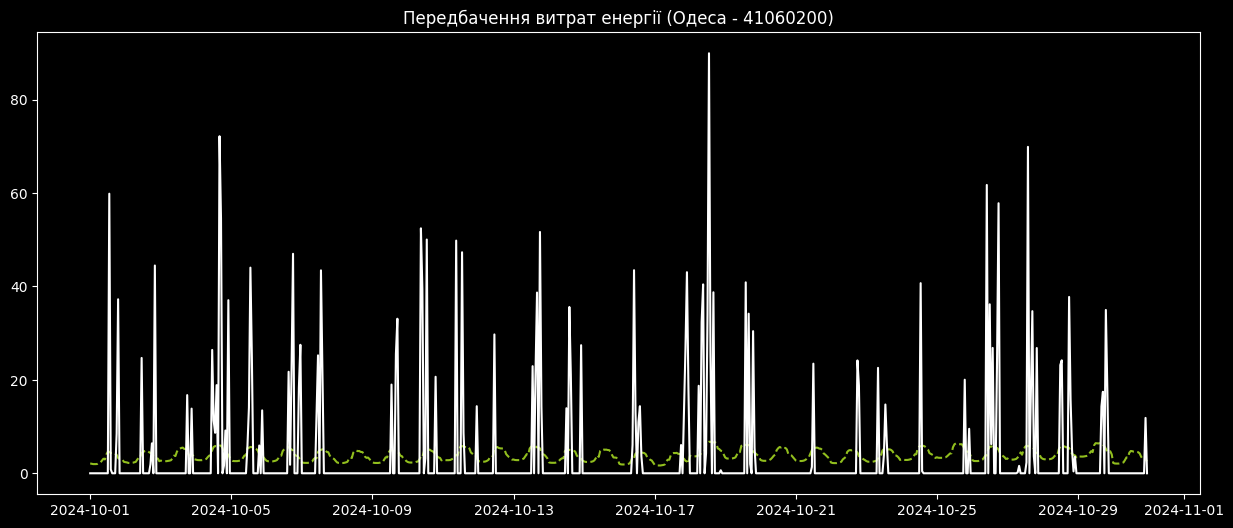

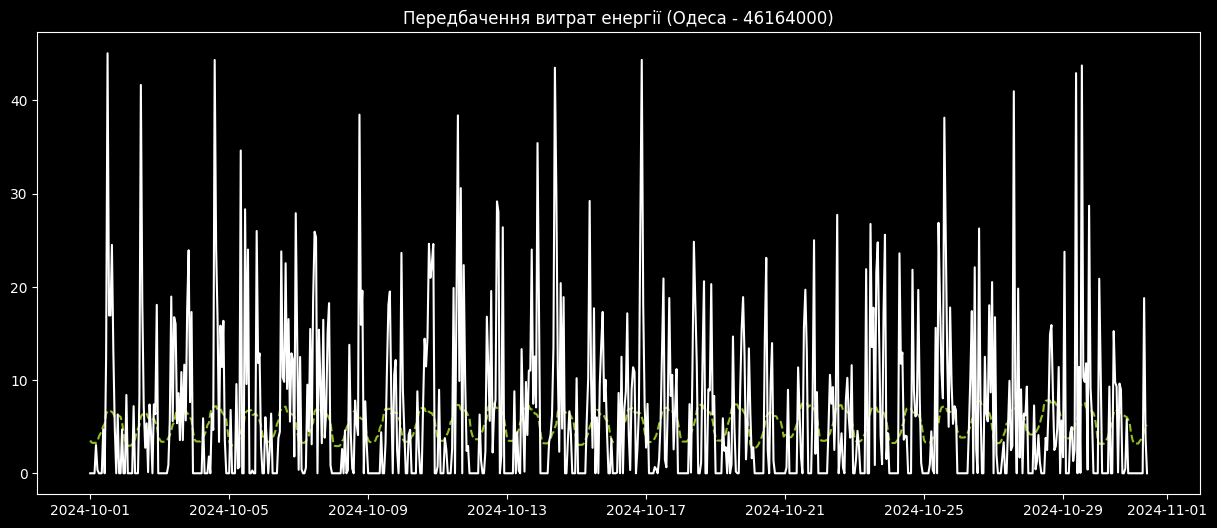

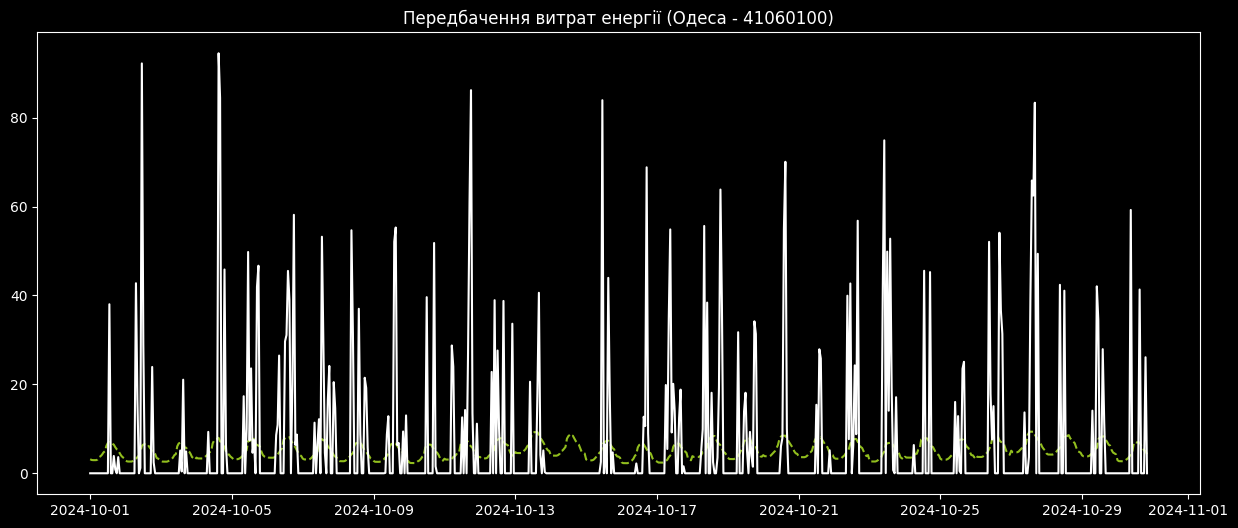

In [297]:
test_odesa = test_odesa.reset_index()
odesa_preds_df = pd.DataFrame(odesa_preds, columns=['preds'])
odesa_preds_df['unicode'] = test_odesa['InternalNum']
odesa_preds_df['time'] = test_odesa['time']
distinct_odesa = test_odesa['InternalNum'].unique()

odesa_station_rmse = {}

for station in distinct_odesa:
    cut_preds = odesa_preds_df[odesa_preds_df['unicode'] == station]
    cut_test = test_odesa[test_odesa['InternalNum'] == station]
    mape = calc_mape(cut_preds['preds'], cut_test['kWh'])
    odesa_station_rmse[station] = mape

# Sort stations by RMSE
sorted_stations = sorted(odesa_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = odesa_preds_df[odesa_preds_df['unicode'] == median_station]
cut_test_median = test_odesa[test_odesa['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Одеса - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = odesa_preds_df[odesa_preds_df['unicode'] == best_station]
cut_test_median = test_odesa[test_odesa['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Одеса - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = odesa_preds_df[odesa_preds_df['unicode'] == worst_station]
cut_test_median = test_odesa[test_odesa['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Одеса - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')


<font>
<font size = '10'>
<center><b>Рівне</b></center></font>

In [298]:
rivne_stations['time'] = pd.to_datetime(rivne_stations['time'])

rivne_stations['year'] = rivne_stations['time'].dt.year
rivne_stations['month'] = rivne_stations['time'].dt.month
rivne_stations['day'] = rivne_stations['time'].dt.day
rivne_stations['day_of_week'] = rivne_stations['time'].dt.weekday
rivne_stations['hour'] = rivne_stations['time'].dt.hour

rivne_stations.tail()

# Filter for test (October 2024)
test_rivne = rivne_stations[(rivne_stations['time'].dt.year == 2024) & (rivne_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_rivne = rivne_stations[(rivne_stations['time'].dt.year == 2024) & (rivne_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_rivne = rivne_stations[(rivne_stations['time'] > '2023-01-01') & (rivne_stations['time'] < '2024-09-01')]

X_train = train_rivne[features]
y_train = train_rivne[target]

X_valid = validation_rivne[features]
y_valid = validation_rivne[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\1938884343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rivne_stations['time'] = pd.to_datetime(rivne_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\1938884343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rivne_stations['year'] = rivne_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\1938884343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [299]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_mape = calc_mape(y_valid, final_preds)
print(f"Optimized XGB RMSE: {final_mape}")

[I 2024-12-18 23:39:04,673] A new study created in memory with name: no-name-c2f4a579-66c9-4472-a800-31b219c2751c
[I 2024-12-18 23:39:07,441] Trial 0 finished with value: 3.8231826215424474 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.28458618666376356, 'subsample': 0.6923698620286018, 'colsample_bytree': 0.8022227200277304, 'gamma': 3.307499802921, 'lambda': 0.0033193756221941446, 'alpha': 0.2666730070814493}. Best is trial 0 with value: 3.8231826215424474.
[I 2024-12-18 23:39:11,980] Trial 1 finished with value: 4.215344118136752 and parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.19280279882818882, 'subsample': 0.7071346005664518, 'colsample_bytree': 0.9208410771500677, 'gamma': 4.900077442083386, 'lambda': 1.7827805977699067, 'alpha': 9.38137812831546}. Best is trial 0 with value: 3.8231826215424474.
[I 2024-12-18 23:39:14,944] Trial 2 finished with value: 3.4523415315422943 and parameters: {'n_estimators': 550, 'max_depth': 4, 'lear

Best Parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.07796753457994568, 'subsample': 0.7577226197932384, 'colsample_bytree': 0.5950787263047115, 'gamma': 8.466378879699546, 'lambda': 0.5846040532772964, 'alpha': 0.3029164384192056}
Optimized XGB RMSE: 3.005415747897247


In [300]:
X_test = test_rivne[features]
y_test = test_rivne[target]

rivne_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 3.0905885585718273


Best RMSE: 0.8964 (Station: 40611700)
Median RMSE: 1.2133 (Station: 40660600)
Worst RMSE: 5.0593 (Station: 40610700)


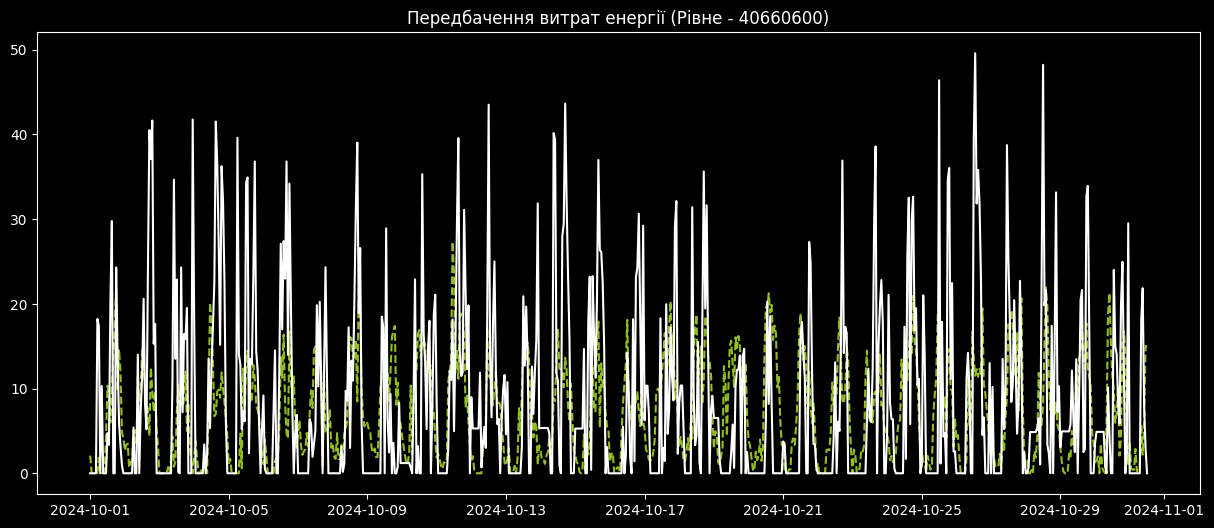

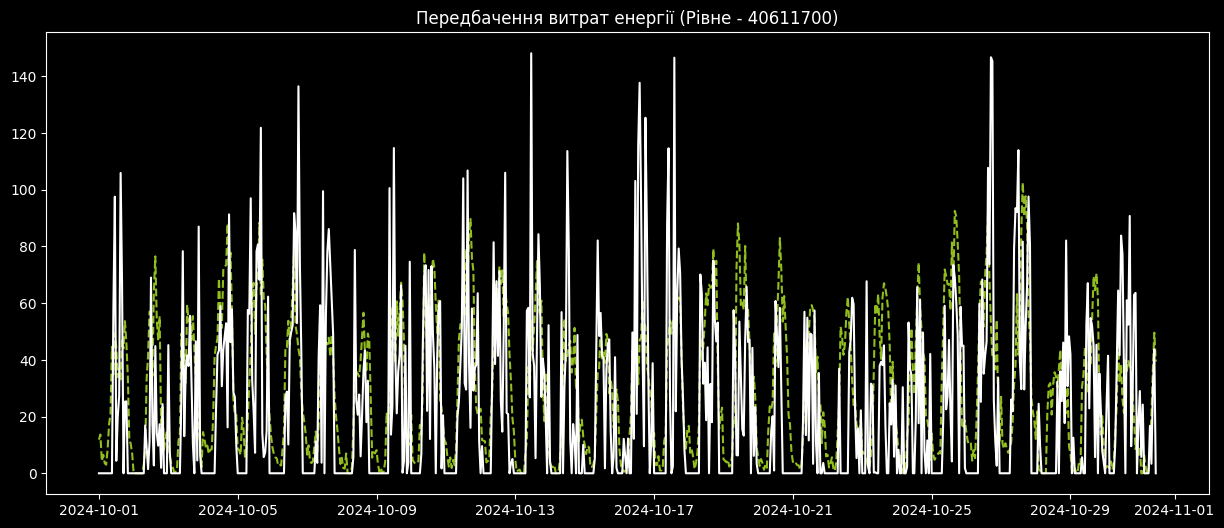

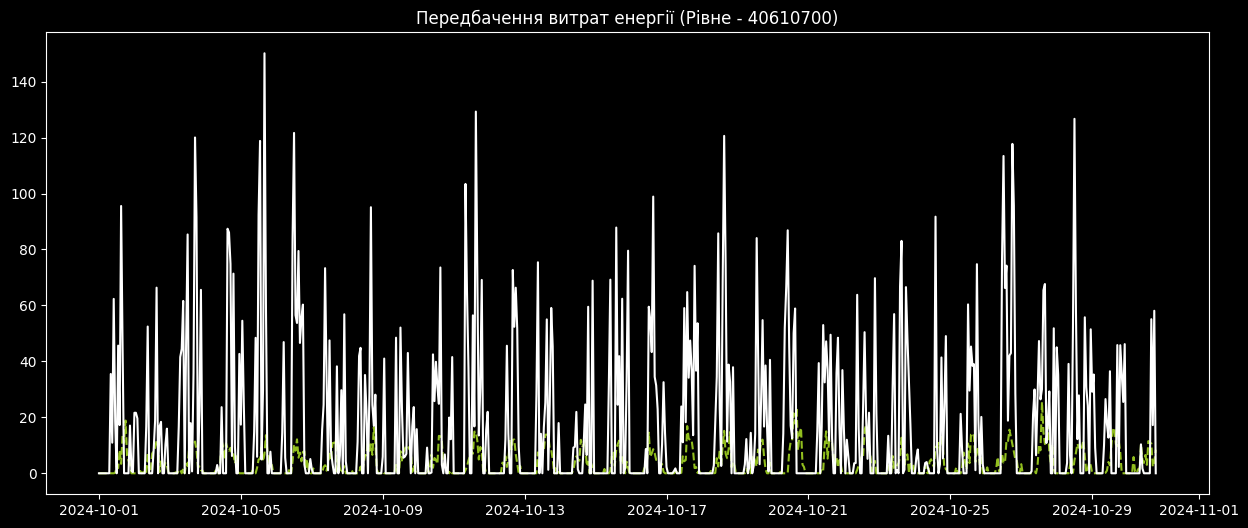

In [301]:
test_rivne = test_rivne.reset_index()
rivne_preds_df = pd.DataFrame(rivne_preds, columns=['preds'])
rivne_preds_df['unicode'] = test_rivne['InternalNum']
rivne_preds_df['time'] = test_rivne['time']
distinct_rivne = test_rivne['InternalNum'].unique()

rivne_station_rmse = {}

for station in distinct_rivne:
    cut_preds = rivne_preds_df[rivne_preds_df['unicode'] == station]
    cut_test = test_rivne[test_rivne['InternalNum'] == station]
    mape = calc_mape(cut_preds['preds'], cut_test['kWh'])
    rivne_station_rmse[station] = mape

# Sort stations by RMSE
sorted_stations = sorted(rivne_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = rivne_preds_df[rivne_preds_df['unicode'] == median_station]
cut_test_median = test_rivne[test_rivne['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Рівне - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = rivne_preds_df[rivne_preds_df['unicode'] == best_station]
cut_test_median = test_rivne[test_rivne['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Рівне - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = rivne_preds_df[rivne_preds_df['unicode'] == worst_station]
cut_test_median = test_rivne[test_rivne['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Рівне - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')
